![iceberg-logo](https://www.apache.org/logos/res/iceberg/iceberg.png)

### [Docker, Spark, and Iceberg: The Fastest Way to Try Iceberg!](https://tabular.io/blog/docker-spark-and-iceberg/)

In [1]:
from pyiceberg import __version__

__version__

'0.2.1'

## Load NYC Taxi/Limousine Trip Data

For this notebook, we will use the New York City Taxi and Limousine Commision Trip Record Data that's available on the AWS Open Data Registry. This contains data of trips taken by taxis and for-hire vehicles in New York City. We'll save this into an iceberg table called `taxis`.

To be able to rerun the notebook several times, let's drop the table if it exists to start fresh.

In [2]:
%%sql

CREATE DATABASE IF NOT EXISTS nyc;

++
||
++
++

In [3]:
%%sql
CREATE TABLE IF NOT EXISTS nyc.taxis (
    VendorID              bigint,
    tpep_pickup_datetime  timestamp,
    tpep_dropoff_datetime timestamp,
    passenger_count       double,
    trip_distance         double,
    RatecodeID            double,
    store_and_fwd_flag    string,
    PULocationID          bigint,
    DOLocationID          bigint,
    payment_type          bigint,
    fare_amount           double,
    extra                 double,
    mta_tax               double,
    tip_amount            double,
    tolls_amount          double,
    improvement_surcharge double,
    total_amount          double,
    congestion_surcharge  double,
    airport_fee           double
)
USING iceberg
PARTITIONED BY (days(tpep_pickup_datetime))

++
||
++
++

In [4]:
%%sql

TRUNCATE TABLE nyc.taxis

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


++
||
++
++

In [5]:
for filename in [
    "yellow_tripdata_2022-04.parquet",
    "yellow_tripdata_2022-03.parquet",
    "yellow_tripdata_2022-02.parquet",
    "yellow_tripdata_2022-01.parquet",
    "yellow_tripdata_2021-12.parquet",
]:
    df = spark.read.parquet(f"/home/iceberg/data/{filename}")
    df.write.mode("append").saveAsTable("nyc.taxis")

## Load data into a PyArrow Dataframe

We'll fetch the table using the REST catalog that comes with the setup.

In [6]:
from pyiceberg.catalog import load_catalog
from pyiceberg.expressions import GreaterThanOrEqual

catalog = load_catalog('default', **{
    'uri': 'http://rest:8181',
    's3.endpoint': 'http://minio:9000',
    's3.access-key-id': 'admin',
    's3.secret-access-key': 'password',
})

In [7]:
tbl = catalog.load_table('nyc.taxis')

sc = tbl.scan(row_filter=GreaterThanOrEqual("tpep_pickup_datetime", "2022-01-01T00:00:00.000000+00:00"))

In [8]:
df = sc.to_arrow().to_pandas()

/usr/local/lib/python3.9/site-packages/pyiceberg/table/__init__.py:339: UserWarning: Projection is currently done by name instead of Field ID, this can lead to incorrect results in some cases.
  warnings.warn(


In [9]:
len(df)

12671129

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12671129 entries, 0 to 12671128
Data columns (total 19 columns):
 #   Column                 Dtype              
---  ------                 -----              
 0   VendorID               int64              
 1   tpep_pickup_datetime   datetime64[ns, UTC]
 2   tpep_dropoff_datetime  datetime64[ns, UTC]
 3   passenger_count        float64            
 4   trip_distance          float64            
 5   RatecodeID             float64            
 6   store_and_fwd_flag     object             
 7   PULocationID           int64              
 8   DOLocationID           int64              
 9   payment_type           int64              
 10  fare_amount            float64            
 11  extra                  float64            
 12  mta_tax                float64            
 13  tip_amount             float64            
 14  tolls_amount           float64            
 15  improvement_surcharge  float64            
 16  total_amount    

In [11]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-01-01 12:45:34+00:00,2022-01-01 13:04:23+00:00,1.0,8.46,1.0,N,138,49,2,25.5,0.0,0.5,0.00,0.00,0.3,27.55,0.0,1.25
1,2,2022-01-01 13:59:29+00:00,2022-01-01 14:06:43+00:00,1.0,2.44,1.0,N,138,7,1,9.5,0.5,0.5,2.41,0.00,0.3,14.46,0.0,1.25
2,2,2022-01-01 14:48:11+00:00,2022-01-01 15:09:25+00:00,1.0,13.03,1.0,N,70,101,2,36.5,0.5,0.5,0.00,0.00,0.3,37.80,0.0,0.00
3,2,2022-01-01 15:42:34+00:00,2022-01-01 16:07:50+00:00,1.0,10.01,1.0,N,138,238,1,30.5,0.5,0.5,8.42,6.55,0.3,50.52,2.5,1.25
4,2,2022-01-01 16:44:38+00:00,2022-01-01 16:59:54+00:00,1.0,8.65,1.0,N,138,140,1,24.5,0.5,0.5,9.02,6.55,0.3,45.12,2.5,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12671124,2,2022-05-03 08:26:41+00:00,2022-05-03 08:35:54+00:00,1.0,1.83,1.0,N,163,238,1,9.0,0.5,0.5,2.56,0.00,0.3,15.36,2.5,0.00
12671125,2,2022-05-03 08:40:25+00:00,2022-05-03 08:50:11+00:00,1.0,1.95,1.0,N,239,163,1,9.0,0.5,0.5,1.00,0.00,0.3,13.80,2.5,0.00
12671126,2,2022-05-03 08:56:56+00:00,2022-05-03 09:11:19+00:00,1.0,0.98,1.0,N,162,230,1,10.0,0.5,0.5,2.00,0.00,0.3,15.80,2.5,0.00
12671127,2,2022-05-03 09:17:10+00:00,2022-05-03 09:33:03+00:00,1.0,2.06,1.0,N,230,43,2,11.5,0.5,0.5,0.00,0.00,0.3,15.30,2.5,0.00


array([[<AxesSubplot: title={'center': 'fare_amount'}>]], dtype=object)

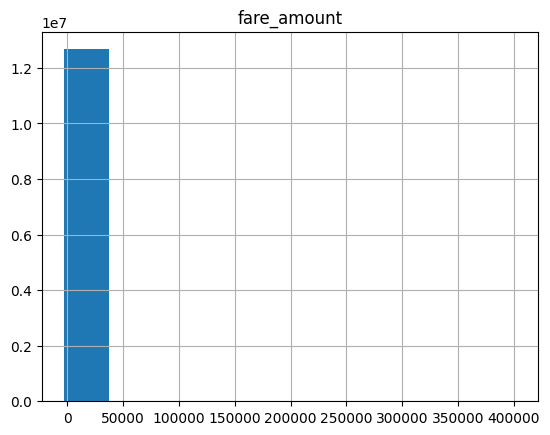

In [12]:
df.hist(column='fare_amount')

In [13]:
import numpy as np
from scipy import stats

stats.zscore(df['fare_amount'])

# Remove everything larger than 3 stddev
df = df[(np.abs(stats.zscore(df['fare_amount'])) < 3)]
# Remove everything below zero
df = df[df['fare_amount'] > 0]

array([[<AxesSubplot: title={'center': 'fare_amount'}>]], dtype=object)

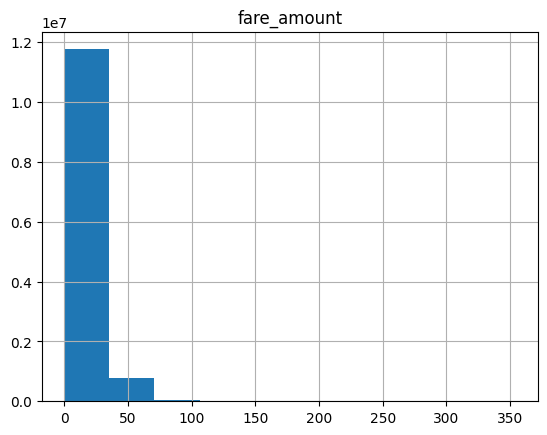

In [14]:
df.hist(column='fare_amount')

# DuckDB

Use DuckDB to Query the PyArrow Dataframe directly.

In [15]:
%load_ext sql
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False
%sql duckdb:///:memory:

In [16]:
%sql SELECT * FROM df LIMIT 20

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2022-01-01 12:45:34,2022-01-01 13:04:23,1.0,8.46,1.0,N,138,49,2,25.5,0.0,0.5,0.00,0.00,0.3,27.55,0.0,1.25
1,2,2022-01-01 13:59:29,2022-01-01 14:06:43,1.0,2.44,1.0,N,138,7,1,9.5,0.5,0.5,2.41,0.00,0.3,14.46,0.0,1.25
2,2,2022-01-01 14:48:11,2022-01-01 15:09:25,1.0,13.03,1.0,N,70,101,2,36.5,0.5,0.5,0.00,0.00,0.3,37.80,0.0,0.00
3,2,2022-01-01 15:42:34,2022-01-01 16:07:50,1.0,10.01,1.0,N,138,238,1,30.5,0.5,0.5,8.42,6.55,0.3,50.52,2.5,1.25
4,2,2022-01-01 16:44:38,2022-01-01 16:59:54,1.0,8.65,1.0,N,138,140,1,24.5,0.5,0.5,9.02,6.55,0.3,45.12,2.5,1.25
5,2,2022-01-01 00:01:16,2022-01-01 00:07:09,3.0,2.45,1.0,N,209,232,2,9.0,0.5,0.5,0.00,0.00,0.3,12.80,2.5,0.00
6,2,2022-01-01 00:01:26,2022-01-01 00:17:13,1.0,6.03,1.0,N,261,161,1,19.5,0.5,0.5,4.66,0.00,0.3,27.96,2.5,0.00
7,2,2022-01-01 00:02:46,2022-01-01 00:08:28,5.0,1.09,1.0,N,237,236,1,6.5,0.5,0.5,2.06,0.00,0.3,12.36,2.5,0.00
8,2,2022-01-01 00:00:25,2022-01-01 00:22:31,3.0,18.30,1.0,N,132,65,1,48.0,0.5,0.5,12.64,0.00,0.3,63.19,0.0,1.25
9,2,2022-01-01 00:09:22,2022-01-01 00:10:57,1.0,0.55,1.0,N,236,236,1,3.5,0.5,0.5,1.46,0.00,0.3,8.76,2.5,0.00


In [17]:
%%sql --save tip-amount --no-execute

SELECT tip_amount
FROM df

Skipping execution...


<AxesSubplot: title={'center': "'tip_amount' from 'df'"}, xlabel='tip_amount', ylabel='Count'>

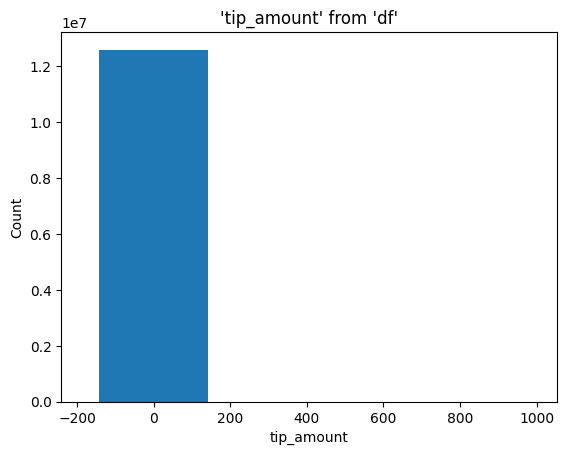

In [18]:
%sqlplot histogram --table df --column tip_amount --bins 22 --with tip-amount


In [19]:
%%sql --save tip-amount-filtered --no-execute

WITH tip_amount_stddev AS (
    SELECT STDDEV_POP(tip_amount) AS tip_amount_stddev
    FROM df
)

SELECT tip_amount
FROM df, tip_amount_stddev
WHERE tip_amount > 0
  AND tip_amount < tip_amount_stddev * 3

Skipping execution...


<AxesSubplot: title={'center': "'tip_amount' from 'tip-amount-filtered'"}, xlabel='tip_amount', ylabel='Count'>

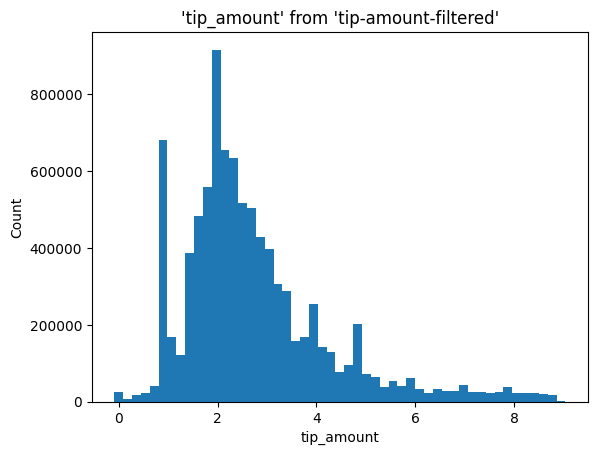

In [20]:
%sqlplot histogram --table tip-amount-filtered --column tip_amount --bins 50 --with tip-amount-filtered


# Iceberg ❤️ PyArrow and DuckDB

This notebook shows how you can load data into a PyArrow dataframe and query it using DuckDB easily. Iceberg allows you to take a slice out of the data that you need for your analysis, while reducing the time that you have to wait for the data and without polluting the memory with data that you're not going to use.